In [26]:
from glob import glob

import numpy as np

from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import optimizers

import matplotlib.pyplot as plt

In [2]:
LABELS = ['apple', 'pear']
TRAIN_DIR = 'images_/train'
VAL_DIR = 'images_/val'
TEST_DIR = 'images_/test'

In [3]:
# from glob import glob
# from sklearn.model_selection import train_test_split


# !mkdir $VAL_DIR

# for l in LABELS:
#     images = glob('%s/%s/*' % (TRAIN_DIR, l))
#     images_train, images_val = train_test_split(images, test_size=0.2)

#     !mkdir $VAL_DIR/$l
#     files = ' '.join(images_val)
#     !mv -t $VAL_DIR/$l $files

In [4]:
def plot_history(history, params=['loss', 'acc']):
    for param in params:
        plt.plot(history.history[param], label='train')
        if 'val_%s' % param in history.history.keys():
            plt.plot(history.history['val_%s' % param], label='test')
        plt.xlabel('epoch')
        plt.ylabel(param)
        plt.title(param.capitalize())
        plt.legend()
        plt.show()

In [5]:
def predict_image(image_path, model, img_size, preproc_func, decode_func):
    image = load_img(image_path)
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    
    image = image.resize(img_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preproc_func(image)
    
    pred = model.predict(image)
    pred = decode_func(pred, top=3)
    title = '\n'.join(['%s (%0.2f%%)' % (p[1].capitalize(), 100 * p[2]) for p in pred[0]])
    
    plt.title(title)
    plt.show()

In [6]:
def predict(model, img):
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    class_probs = model.predict(x)[0]
    labels = [LABELS[i] for i in np.argsort(class_probs)[::-1][:3]]
    confs = np.sort(class_probs)[::-1][:3]
    
    return labels, 100 * confs

    
def predict_test_images(model):
    test_images = glob('%s/*' % TEST_DIR)
    h, w = np.ceil(len(test_images) / 3), 3
    
    plt.figure(figsize=(5 * w, 5 * h))

    for i, img_file in enumerate(test_images):
        plt.subplot(h, w, i + 1)
        img = load_img(img_file, target_size=(HEIGHT, WIDTH))
        labels, confs = predict(model, img)
        plt.imshow(np.asarray(img))
        title = '\n'.join(['%s (%0.2f%%)' % (label, conf) for label, conf in zip(labels, confs)])
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [7]:
def show_most_confident_predictions(ds, model, h=5, w=5):
    n_img = min(h * w, ds.shape[0])
    
    preds = model.predict(ds, verbose=0)
    most_conf = np.argsort(np.max(preds, axis=1))[-n_img::-1]
    x = ds[most_conf]
    preds = [preds[i] for i in most_conf]
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))
    for i in range(n_img):
        plt.subplot(h, w, i + 1)
        image = x[i].reshape(W, H, n_channels)
        plt.imshow(image)
        title = '%s\n%0.2f%%' % (LABELS[np.argmax(preds[i])], 100 * np.max(preds[i]))
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [8]:
incv3 = InceptionV3(weights='imagenet', include_top=True)
incv3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

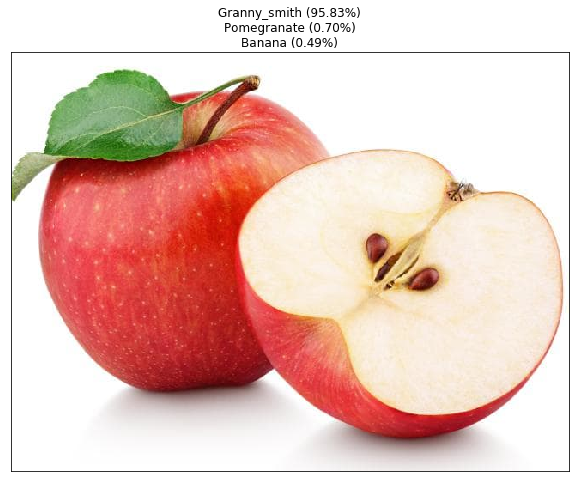

In [9]:
predict_image('images_/test/test_0002.jpg', incv3, (299, 299), 
              preprocess_input, 
              decode_predictions)

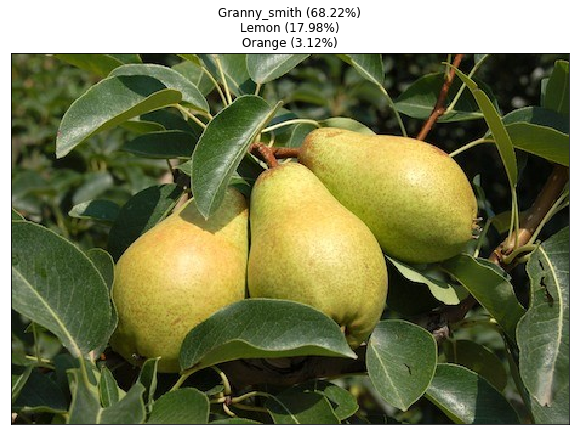

In [10]:
predict_image('images_/test/test_0006.jpg', incv3, (299, 299), 
              preprocess_input, 
              decode_predictions)

In [11]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output

x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)

predictions = Dense(len(LABELS), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer=optimizers.rmsprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
WIDTH = 150
HEIGHT = 150
BATCH_SIZE = 16

In [13]:
img_gen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

img_gen_validation = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = img_gen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')    
validation_generator = img_gen_validation.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 1322 images belonging to 2 classes.
Found 334 images belonging to 2 classes.


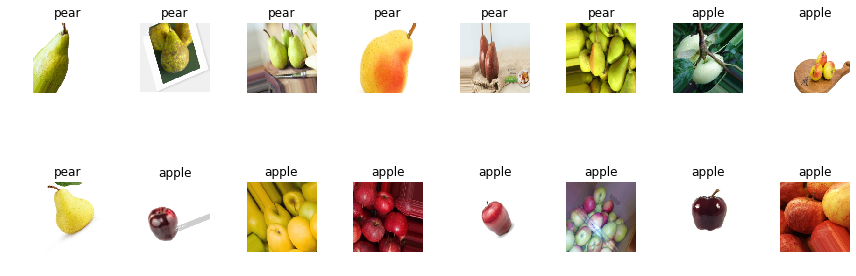

In [14]:
x_batch, y_batch = next(train_generator)
h, w = 4, 8

plt.figure(figsize=(12, 9))
for i, (img, class_probs) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(h, w, i + 1)
    plt.imshow((img + 1) / 2)
    plt.title(LABELS[np.argmax(class_probs)])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
EPOCHS = 50

tb = TensorBoard(log_dir="logs", write_graph=True, write_images=True)
# check = ModelCheckpoint('models/model_epoch_{epoch:02d}_val_top_3_acc_{val_top_3_acc:.5f}.hdf5',
#                        monitor='top_3_acc',
#                        mode='max',
#                        save_best_only=True)

In [16]:
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[tb],
    steps_per_epoch=len(train_generator),
    validation_steps=20)

Epoch 1/50


/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 8/83 [=>............................] - ETA: 1:51 - loss: 0.8226 - acc: 0.5391

/usr/lib/python3/dist-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


83/83 [==============================] - 126s 2s/step - loss: 0.7701 - acc: 0.5747 - val_loss: 0.7927 - val_acc: 0.6188
Epoch 2/50
83/83 [==============================] - 104s 1s/step - loss: 0.6742 - acc: 0.6467 - val_loss: 0.8517 - val_acc: 0.6447
Epoch 3/50
83/83 [==============================] - 124s 1s/step - loss: 0.6196 - acc: 0.6888 - val_loss: 2.0482 - val_acc: 0.5189
Epoch 4/50
83/83 [==============================] - 114s 1s/step - loss: 0.5805 - acc: 0.7140 - val_loss: 1.7621 - val_acc: 0.5629
Epoch 5/50
83/83 [==============================] - 105s 1s/step - loss: 0.5498 - acc: 0.7306 - val_loss: 1.6326 - val_acc: 0.5755
Epoch 6/50
83/83 [==============================] - 103s 1s/step - loss: 0.5250 - acc: 0.7548 - val_loss: 2.3421 - val_acc: 0.5377
Epoch 7/50
83/83 [==============================] - 105s 1s/step - loss: 0.5349 - acc: 0.7416 - val_loss: 1.4077 - val_acc: 0.6164
Epoch 8/50
83/83 [==============================] - 123s 1s/step - loss: 0.5253 - acc: 0.7551 

In [17]:
model.save('bn_head_50_epochs.hdf5')

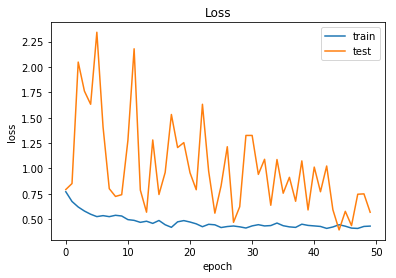

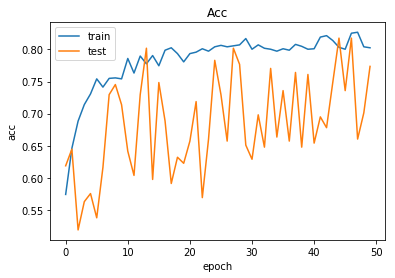

In [18]:
plot_history(history)

In [19]:
score = model.evaluate_generator(validation_generator, steps=30)

In [20]:
acc = 100 * score[1]
print('Model val accuracy: %0.3f%%' % acc)

Model val accuracy: 74.268%


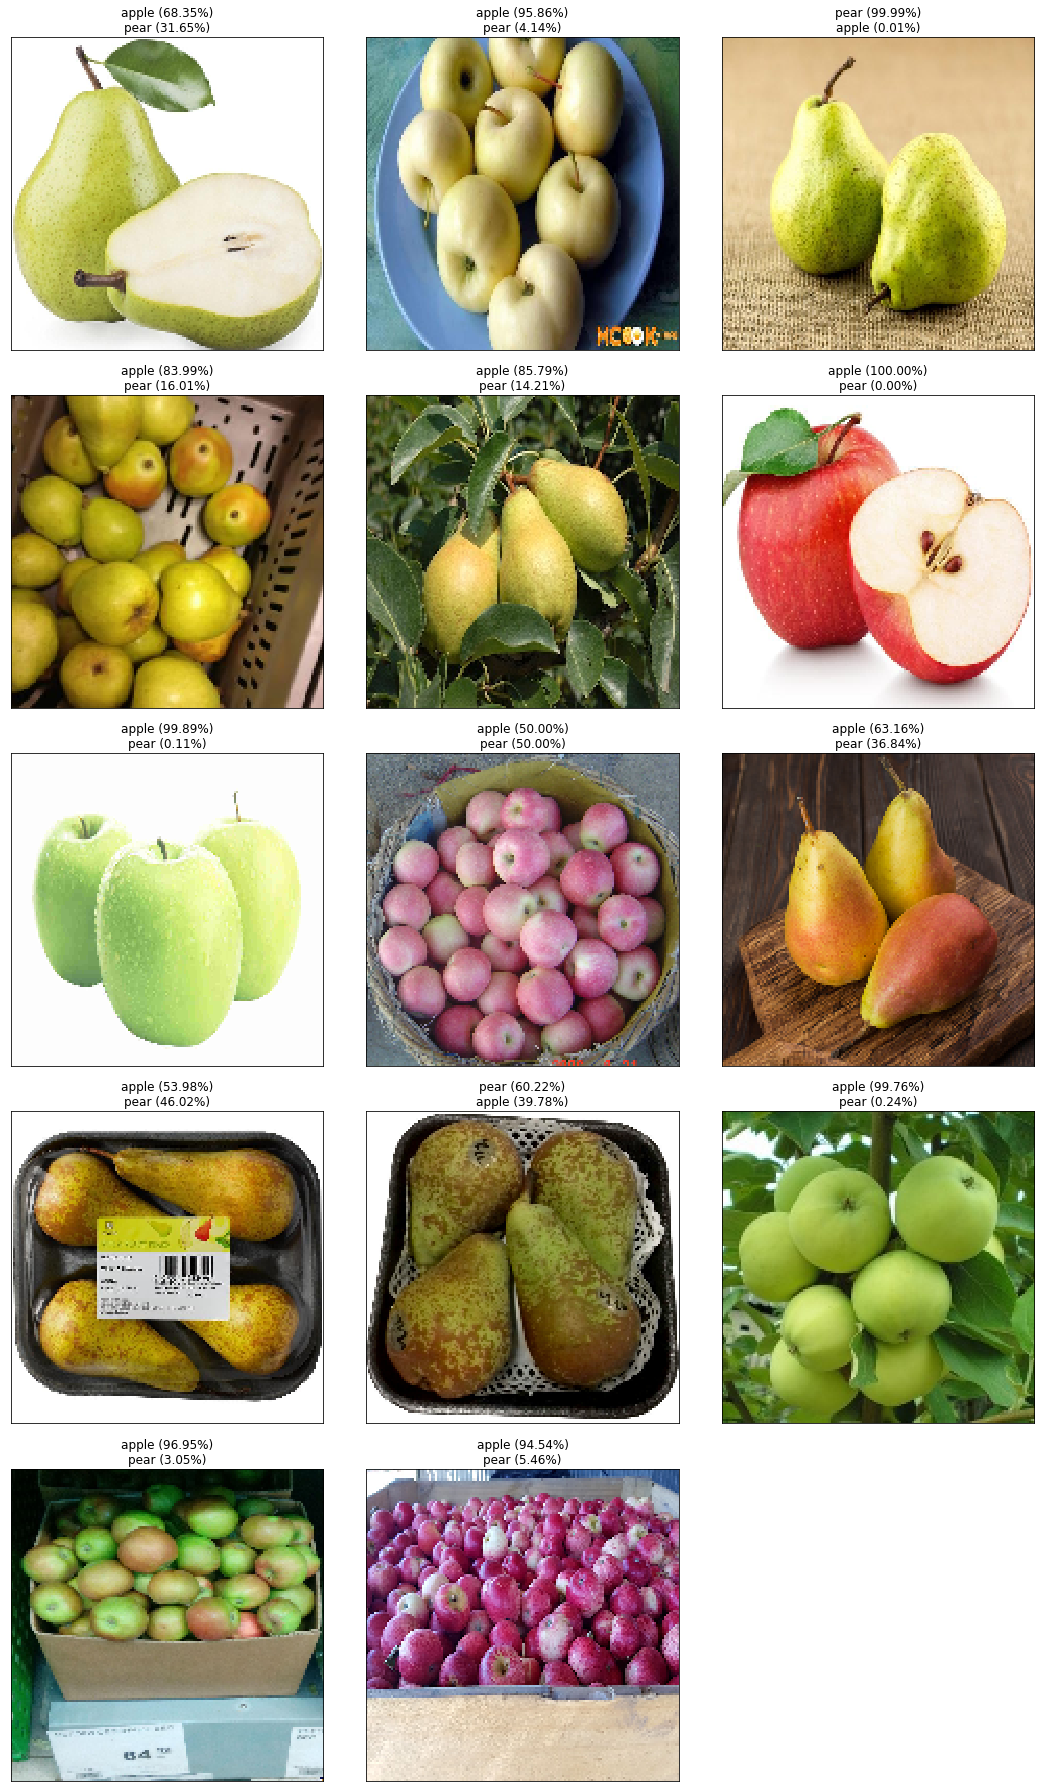

In [27]:
predict_test_images(model)

In [28]:
tb = TensorBoard(log_dir="logs", write_graph=True, write_images=True)

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [29]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=2 * len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=20,
    callbacks=[tb])

Epoch 1/50
166/166 [==============================] - 253s 2s/step - loss: 0.3735 - acc: 0.8228 - val_loss: 0.4070 - val_acc: 0.8553
Epoch 2/50
166/166 [==============================] - 241s 1s/step - loss: 0.3733 - acc: 0.8392 - val_loss: 0.4525 - val_acc: 0.8302
Epoch 3/50
166/166 [==============================] - 240s 1s/step - loss: 0.3411 - acc: 0.8415 - val_loss: 0.3984 - val_acc: 0.8500
Epoch 4/50
166/166 [==============================] - 247s 1s/step - loss: 0.3309 - acc: 0.8563 - val_loss: 0.4506 - val_acc: 0.8208
Epoch 5/50
166/166 [==============================] - 240s 1s/step - loss: 0.3096 - acc: 0.8629 - val_loss: 0.4270 - val_acc: 0.8239
Epoch 6/50
166/166 [==============================] - 244s 1s/step - loss: 0.3337 - acc: 0.8541 - val_loss: 0.3976 - val_acc: 0.8302
Epoch 7/50
166/166 [==============================] - 243s 1s/step - loss: 0.3212 - acc: 0.8568 - val_loss: 0.4166 - val_acc: 0.8333
Epoch 8/50
166/166 [==============================] - 245s 1s/step - 

In [30]:
model.save('bn_unfreezed_head_50_epochs.hdf5')

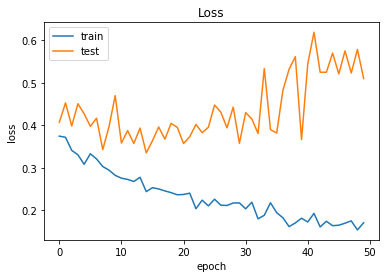

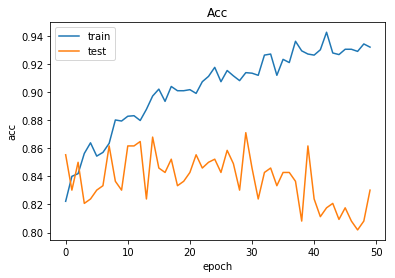

In [31]:
plot_history(history)

In [32]:
score = model.evaluate_generator(validation_generator, steps=30)

In [33]:
Epoch 1/50
166/166 [==============================] - 253s 2s/step - loss: 0.3735 - acc: 0.8228 - val_loss: 0.4070 - val_acc: 0.8553
Epoch 2/50
166/166 [==============================] - 241s 1s/step - loss: 0.3733 - acc: 0.8392 - val_loss: 0.4525 - val_acc: 0.8302
Epoch 3/50
166/166 [==============================] - 240s 1s/step - loss: 0.3411 - acc: 0.8415 - val_loss: 0.3984 - val_acc: 0.8500
Epoch 4/50
166/166 [==============================] - 247s 1s/step - loss: 0.3309 - acc: 0.8563 - val_loss: 0.4506 - val_acc: 0.8208
Epoch 5/50
166/166 [==============================] - 240s 1s/step - loss: 0.3096 - acc: 0.8629 - val_loss: 0.4270 - val_acc: 0.8239
Epoch 6/50
166/166 [==============================] - 244s 1s/step - loss: 0.3337 - acc: 0.8541 - val_loss: 0.3976 - val_acc: 0.8302
Epoch 7/50
166/166 [==============================] - 243s 1s/step - loss: 0.3212 - acc: 0.8568 - val_loss: 0.4166 - val_acc: 0.8333
Epoch 8/50
166/166 [==============================] - 245s 1s/step - loss: 0.3030 - acc: 0.8636 - val_loss: 0.3428 - val_acc: 0.8616
Epoch 9/50
166/166 [==============================] - 243s 1s/step - loss: 0.2942 - acc: 0.8800 - val_loss: 0.3965 - val_acc: 0.8365
Epoch 10/50
166/166 [==============================] - 244s 1s/step - loss: 0.2826 - acc: 0.8792 - val_loss: 0.4696 - val_acc: 0.8302
Epoch 11/50
166/166 [==============================] - 263s 2s/step - loss: 0.2758 - acc: 0.8828 - val_loss: 0.3583 - val_acc: 0.8616
Epoch 12/50
166/166 [==============================] - 249s 2s/step - loss: 0.2731 - acc: 0.8828 - val_loss: 0.3874 - val_acc: 0.8616
Epoch 13/50
166/166 [==============================] - 241s 1s/step - loss: 0.2690 - acc: 0.8789 - val_loss: 0.3573 - val_acc: 0.8648
Epoch 14/50
166/166 [==============================] - 239s 1s/step - loss: 0.2789 - acc: 0.8875 - val_loss: 0.3934 - val_acc: 0.8239
Epoch 15/50
166/166 [==============================] - 263s 2s/step - loss: 0.2441 - acc: 0.8974 - val_loss: 0.3352 - val_acc: 0.8679
Epoch 16/50
166/166 [==============================] - 242s 1s/step - loss: 0.2533 - acc: 0.9020 - val_loss: 0.3638 - val_acc: 0.8459
Epoch 17/50
166/166 [==============================] - 241s 1s/step - loss: 0.2502 - acc: 0.8938 - val_loss: 0.3959 - val_acc: 0.8428
Epoch 18/50
166/166 [==============================] - 241s 1s/step - loss: 0.2463 - acc: 0.9039 - val_loss: 0.3674 - val_acc: 0.8522
Epoch 19/50
166/166 [==============================] - 243s 1s/step - loss: 0.2422 - acc: 0.9000 - val_loss: 0.4045 - val_acc: 0.8333
Epoch 20/50
166/166 [==============================] - 241s 1s/step - loss: 0.2382 - acc: 0.9005 - val_loss: 0.3951 - val_acc: 0.8365
Epoch 21/50
166/166 [==============================] - 242s 1s/step - loss: 0.2390 - acc: 0.9008 - val_loss: 0.3571 - val_acc: 0.8428
Epoch 22/50
166/166 [==============================] - 291s 2s/step - loss: 0.2407 - acc: 0.8992 - val_loss: 0.3732 - val_acc: 0.8553
Epoch 23/50
166/166 [==============================] - 321s 2s/step - loss: 0.2036 - acc: 0.9075 - val_loss: 0.4019 - val_acc: 0.8459
Epoch 24/50
166/166 [==============================] - 332s 2s/step - loss: 0.2241 - acc: 0.9111 - val_loss: 0.3827 - val_acc: 0.8500
Epoch 25/50
166/166 [==============================] - 317s 2s/step - loss: 0.2103 - acc: 0.9179 - val_loss: 0.3953 - val_acc: 0.8522
Epoch 26/50
166/166 [==============================] - 353s 2s/step - loss: 0.2282 - acc: 0.9073 - val_loss: 0.4477 - val_acc: 0.8428
Epoch 27/50
166/166 [==============================] - 298s 2s/step - loss: 0.2125 - acc: 0.9152 - val_loss: 0.4310 - val_acc: 0.8585
Epoch 28/50
166/166 [==============================] - 353s 2s/step - loss: 0.2127 - acc: 0.9105 - val_loss: 0.3941 - val_acc: 0.8491
Epoch 29/50
166/166 [==============================] - 357s 2s/step - loss: 0.2178 - acc: 0.9081 - val_loss: 0.4428 - val_acc: 0.8302
Epoch 30/50acc = 100 * score[1]
print('Model val accuracy: %0.3f%%' % acc)

Model val accuracy: 82.427%


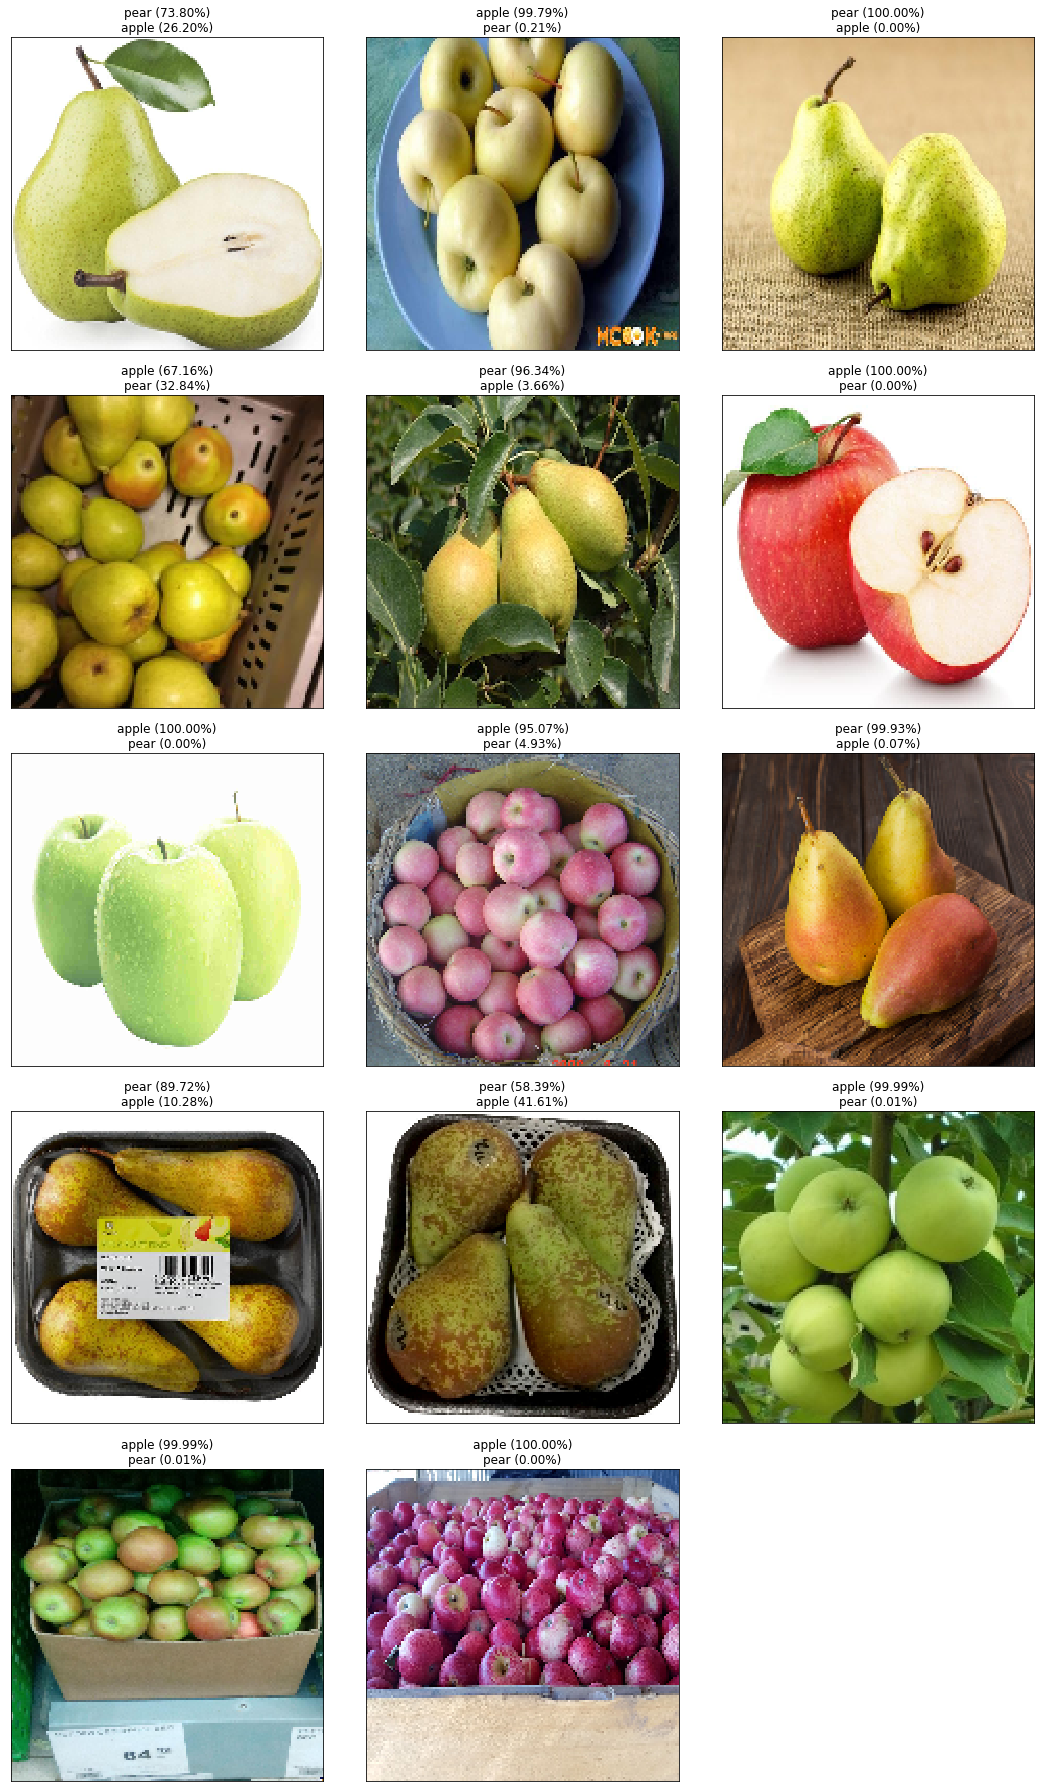

In [34]:
predict_test_images(model)

In [ ]:
# show_most_confident_predictions(x_val, model)